In [5]:
import os, sys
import pickle
import polars as pl

In [ ]:
# Define el ID del experimento que quieres analizar
DATA_ID = 'heart_disease' 
N_REALIZATIONS = 100

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) 
results_dir = os.path.join(project_path, 'results', 'experiment_3', DATA_ID)
filename = f'results_exp_3_{DATA_ID}.pkl'
results_path = os.path.join(results_dir, filename)

sys.path.append(project_path)

from src.experiments_utils import plot_experiment_3_results
from config.config_experiment_3 import (
    PROP_ERRORS_THRESHOLD,
    #N_REALIZATIONS
)

In [ ]:
# -------------------------------------------------------------------------
# CARGAR RESULTADOS
# -------------------------------------------------------------------------
if not os.path.exists(results_path):
    print("❌ Error: El archivo no existe. Revisa el DATA_ID o la ruta.")
else:
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print(f"✅ Archivo cargado correctamente. Tipo de objeto: {type(results)}")
    print(f"📊 Número de realizaciones (seeds) capturadas: {len(results)}")

# -------------------------------------------------------------------------
# CONVERSIÓN A DATAFRAME  
# -------------------------------------------------------------------------
rows = []
for seed, metrics in results.items():   
    # Asumimos que todas las métricas tienen las mismas claves (frac_sample_sizes)
    n_splits_arr = metrics['ARI'].keys() 
    frac_sample_size_arr = metrics['ARI'][list(n_splits_arr)[0]].keys()
    
    for n_splits in n_splits_arr:
        for frac in frac_sample_size_arr:        
            row = {
                'random_state': seed,
                'n_splits': n_splits,
                'frac_sample_size': frac,
                'time': metrics['time'].get(n_splits).get(frac),
                'adj_accuracy': metrics['adj_accuracy'].get(n_splits).get(frac),
                'ARI': metrics['ARI'].get(n_splits).get(frac),
                'status': metrics['status'].get(n_splits).get(frac) if 'status' in metrics else 'OK',
            }
            rows.append(row)

df = pl.DataFrame(rows)

df = df.with_columns(
        pl.when(
            pl.col('status').str.contains('Error')
        ).then(
            True
        ).otherwise(
            False
        ).alias('status_error')
    )

df_avg = (
    df.group_by(['n_splits', 'frac_sample_size'])
    .agg(pl.mean(['ARI', 'adj_accuracy', 'time', 'status_error']))
    .sort(['n_splits', 'frac_sample_size'])
)

df_avg = df_avg.filter(pl.col('status_error') < PROP_ERRORS_THRESHOLD)

✅ Archivo cargado correctamente. Tipo de objeto: <class 'dict'>
📊 Número de realizaciones (seeds) capturadas: 100


In [8]:
df_avg

n_splits,frac_sample_size,ARI,adj_accuracy,time,status_error
i64,f64,f64,f64,f64,f64
3,0.2,0.076071,0.62101,2.146862,0.0
3,0.3,0.080965,0.622896,2.110856,0.0
3,0.4,0.091103,0.635455,2.149413,0.0
3,0.5,0.107134,0.645219,2.179837,0.0
3,0.6,0.127286,0.66138,2.144264,0.0
…,…,…,…,…,…
10,0.5,0.064282,0.617374,5.656775,0.0
10,0.6,0.066123,0.619562,5.540577,0.0
10,0.7,0.076282,0.626532,5.638731,0.0


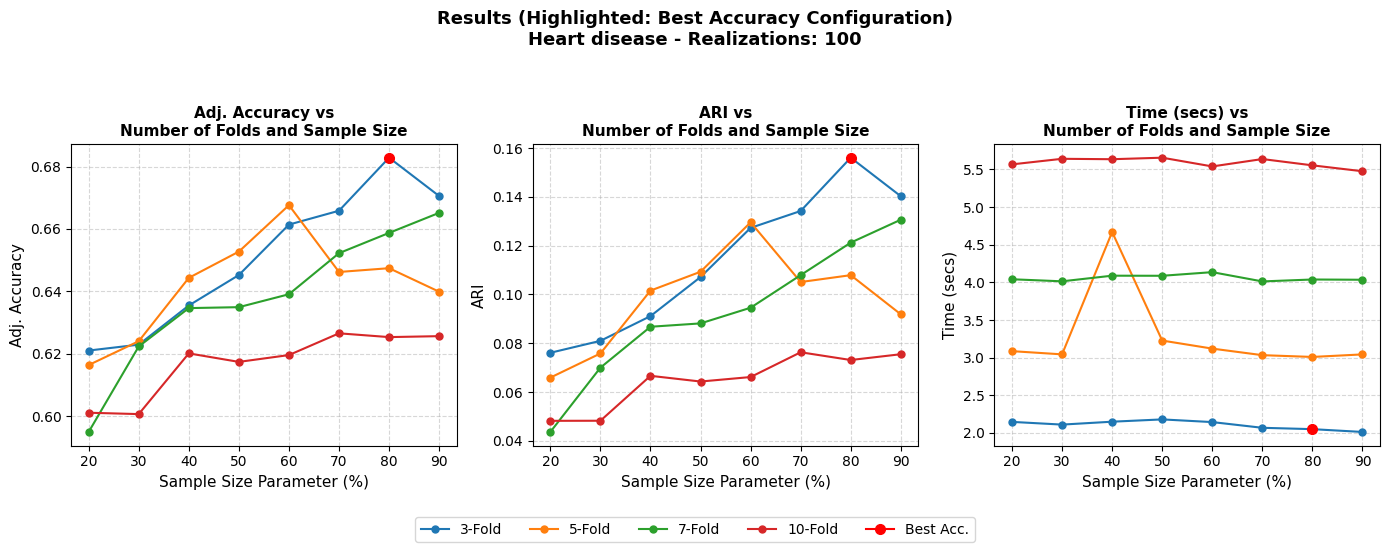

In [9]:
plot_filename = f'plot_results_exp_multifold_{DATA_ID}.png'
save_path = os.path.join(results_dir, plot_filename)

plot_experiment_3_results(
    df=df_avg,                  
    data_name=DATA_ID,          
    num_realizations=100,       
    save_path=save_path
)